In [1]:
from matplotlib import pyplot as plt
from IPython import display
import numpy as np
import random
from matplotlib import colors
import copy
import time
import scipy.optimize

%matplotlib inline

The functions below form the core of the simulation. Note that we haven't bothered to write a function for computing magnetization, because the magnetization is just the sum of the spins on the lattice.

In [2]:
# assumes periodic BCs
def metropolis_ising(init, boltz):
    """Returns a mesh evolved by one step of applying the Metropolis algorithm, the energy change, 
    and the magnetization change"""
    
    mesh = copy.copy(init)
    
    X = np.shape(mesh)[1]
    Y = np.shape(mesh)[0]
    
    # select random spin from the input spin mesh
    x = random.choice(range(X))
    y = random.choice(range(Y))
    
    # applying the metropolis algorithm
    spin_sum = (mesh[(y+1) % Y,x ] + mesh[y ,(x+1) % X] + mesh[(y-1) % Y,x ] + mesh[y ,(x-1) % X])
    d_energy = 2*mesh[y,x] * spin_sum
    
    if d_energy <= 0:
        mesh[y,x] = -1*mesh[y,x]
        d_mag = 2*mesh[y,x]
        
    elif random.uniform(0,1) < boltz[str(abs(spin_sum))]:
        mesh[y,x] = -1*mesh[y,x]
        d_mag = 2*mesh[y,x]
        
    else:
        d_energy = 0
        d_mag = 0
        

    return [mesh, d_energy, d_mag]

In [3]:
def plot_ising_grid(init, title):
    """Creates a discrete colormap for an input Ising grid, red for up (1) and blue for down (-1)"""
    X = np.shape(init)[1]
    Y = np.shape(init)[0]
    
    cmap = colors.ListedColormap(['blue', 'red'])
    bounds = [0,1,1]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    
    fig, ax = plt.subplots(figsize=(6,6))
    plt.imshow(init, cmap=cmap, norm=norm)
    plt.title(title, fontsize=20)
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

    display.clear_output(wait = True)

    plt.show()

In [4]:
def mc_step(init, boltz, n, plot = False, final_only = False):
    """Plots n-step evolution of an Ising model using Metropolis and returns the final grid"""
    
    grid = copy.copy(init)
    
    for i in range(n):    
        # evolve using metropolis
        grid = metropolis_ising(grid, boltz)[0]
        
        if plot == True:
            # plotting
            if final_only == False:    
                plot_ising_grid(grid, f'2D Ising Model; n = {i+1}')


            else:
                if i == n-1:
                    plot_ising_grid(grid, f'2D Ising Model; n = {i+1}')
        
    return grid

In [5]:
# variant of the above that only returns the grid after 1 sweep
# faster than the single-step program when simulating for very long times
def mc_sweep(init, boltz):
    
    grid = copy.copy(init)
    
    X = np.shape(grid)[1]
    Y = np.shape(grid)[0]
    
    for j in range(X):
        for i in range(Y):
            x = np.random.randint(X)
            y = np.random.randint(Y)
            spin = grid[y,x]
            
            spin_sum = grid[(y+1) % Y,x ] + grid[y ,(x+1) % X] + grid[(y-1) % Y,x ] + grid[y ,(x-1) % X]
            d_energy = 2 * spin * spin_sum

            if d_energy <= 0:
                grid[y,x] = -1*grid[y,x]
              #  d_mag = 2*grid[y,x]

            elif random.uniform(0,1) < boltz[str(abs(spin_sum))]:
                grid[y,x] = -1*grid[y,x]
            #    d_mag = 2*grid[y,x]

           # else:
           #     d_energy = 0
           #     d_mag = 0
        
    return grid
                
    

In [6]:
def ising_energy(init):
    """Computes the energy of a 2D square lattice in the Ising model"""
    
    X = np.shape(init)[1]
    Y = np.shape(init)[0]
    
    energy = 0
    
    for i in range(Y):
        for j in range(X):
            energy += -1 * init[i,j] * (init[(i+1) % Y ,j] + init[(i-1) % Y,j] + init[i,(j+1) % X] + init[i,(j-1) % X])
            
    energy = energy/2
    
    return energy

The following functions are auxiliary; they are used to check various properties of the simulation, like equilibration time or thermodynamic properties.

In [7]:
def energy_evo(init, boltz, n, plot = True):
    """Returns a list of energies for a 2D Ising grid from every timestep and plots the list"""

    X = np.shape(init)[1]
    Y = np.shape(init)[0]
    total = X*Y
    
    grid = copy.copy(init)
    
    # energy
    energy = ising_energy(grid)
    energy_list = [energy]
    
    # evolution
    for i in range(n):
        grid, d_energy, d_mag = metropolis_ising(grid, boltz)
        
        # increment energy
        energy += d_energy
        energy_list.append(energy)

    
    if plot == True:
        # plotting
        x_axis = [i/total for i in range(n+1)]

        plt.figure(figsize=(6,6))
        plt.plot(x_axis,energy_list)
        plt.tick_params(axis='both', which='major', labelsize=12)
        plt.xlabel('Sweeps', fontsize=20)
        plt.ylabel('Energy', fontsize=20)
        plt.title(f'Energy of Ising Grid', fontsize=20)

    return energy_list


In [8]:
def magps(init, boltz, n, plot = True):
    """Returns a list of mag. per spin for a 2D Ising grid from every timestep and plots the list"""

    X = np.shape(init)[1]
    Y = np.shape(init)[0]
    total = X*Y
    
    grid = copy.copy(init)
    
    # magnetization
    mag = np.sum(grid)
    mag_list = [mag/total]
    
    # evolution
    for i in range(n):
        grid, d_energy, d_mag = metropolis_ising(grid, boltz)
        
        # increment magnetization
        mag += d_mag
        mag_list.append(mag/total)

    if plot == True:
        # plotting
        x_axis = [i/total for i in range(n+1)]

        plt.figure(figsize=(6,6))
        plt.plot(x_axis,mag_list)
        plt.tick_params(axis='both', which='major', labelsize=12)
        plt.xlabel('Sweeps', fontsize=20)
        plt.ylabel('Magnetization per Spin', fontsize=20)
        plt.title(f'Magnetization per Spin of Ising Grid', fontsize=20)
    
    
    return mag_list

The following function are measurements that involve means. To get accurate means, one should probably sample with a frequency no greater than once per sweep, i.e. once per N number of MC steps, where N is the number of spins on the lattice.

In [10]:
# keep in mind sampling frequency for the energies in energy_list
def spec_heat_ps(energy_list, T, N):
    """Compute the specific heat per spin for an input list of energy values at temperature T and lattice sites N"""
    
    if type(energy_list) is list:
        energy_list = np.array(energy_list)
    
    c = (1/(T**2 * N)) * np.var(energy_list)
    
    return c

In [11]:
def sus(mag_list, T, N):
    """Compute susceptibility for an input list of magnetization values at temperature T and lattice sites N"""
    
    if type(mag_list) is list:
        mag_list = np.array(mag_list)
    
    chi = (1/(T*N)) * np.var(mag_list)
    
    return chi

In [13]:
def ss_cor(init, boltz, n_sweep, n_equil, s1, s2):
    """Compute the mean correlation between spins s1 and s2"""
    
    grid = copy.copy(init)
    
    cor = 0
    
    # evolve to equilibrium
    for i in range(n_equil):
        grid = sweep(grid, boltz)
        
    # set the equilibrium value after which measurements will be made
    for j in range(n_sweep):
        grid = mc_sweep(grid, boltz)
        cor += grid[s1[0],s1[1]] * grid[s2[0],s2[1]]
    
        
    cor = cor/(n_sweep)
    
    return cor

In [14]:
# c_list is a list of specific heats per spin computed at the evenly-spaced, 
# ascending-ordered temperatures on temp_list
# s_0 is the entropy per spin at the the minimum of temp_list 
def ent_ps(temp_list, c_list, s_0):
    """Compute the entropy of an Ising lattice using the trapezoidal rule for a given set of temperatures and c"""
    
    dT = temp_list[1] - temp_list[0]
    n = len(temp_list)
    
    # compute the boundary terms
    t_min = temp_list[0]
    t_max = temp_list[-1]
    
    c_1 = c_list[0]
    c_2 = c_list[-1]
    
    boundary = (c_2/t_max + c_1/t_min)
    
    
    # initialize the integral sum
    integral = boundary
    
    for i in range(1,n-1):
        integral += c_list[i]/temp_list[i]
        
    integral = integral*dT
    
    # include the integration constant
    s = s_0 + integral
    
    return s
    

Below is the bootstrap code to compute an error

In [15]:
def bootstrap_mean(values_list, n):
    """Uses the bootstrap method to compute the error in the mean of a given list of values"""
    
    values = copy.copy(values_list)
    ns = len(values)
    
    means = []
    
    for i in range(n):
        samples = np.random.choice(values, ns)
        print(samples)
        means.append(np.mean(samples))
    
    error = np.std(means)
    
    return error
    
    
    

In [16]:
def bootstrap_c(energies, T, N, n):
    """Uses bootstrap to compute the error in the specific heat for an input set of energies"""
    
    e_list = copy.copy(energies)
    ns = len(e_list)
    
    values = []
    
    for i in range(n):
        samples = np.random.choice(e_list, ns)
        values.append(spec_heat_ps(samples, T, N))
        
    error = np.std(values)
    
    return error
        

In [17]:
def bootstrap_s(magps, T, N, n):
    """Uses bootstrap to compute the error in the susceptibility for an input set of magnetization"""
    
    mps_list = [i for i in magps]
    ns = len(mps_list)
    
    values = []
    
    for i in range(n):
        samples = np.random.choice(mps_list, ns)
        values.append(sus(mps_list, T, N))
    
    error = np.std(values)
    
    return error
        

Below is some code used to explore the temperature range around the critical temperature, as well as a rudimentary attempt to obtain a value for the critical temperature and critcal exponents. Because the efforts are rudimentary and the computations take a lot of time, there has been no attempt to modularize the code.

In [18]:
def round_to_3(x):
    if x != 0:
        return round(x, -int(np.floor(np.log10(abs(x)))) + 2)
    else:
        return 0

In [27]:
# exploring the temperature range around the critical temp

temps = [t for t in np.arange(1.6, 2.91, .01)]
for i in range(len(temps)):
    temps[i] = round_to_3(temps[i])
    
t_points = len(temps)

# initialize dictionaries to store values
energy_dict8 = {}
mag_dict8 = {}

for T in temps:
    energy_dict8[str(T)] = []
    mag_dict8[str(T)] = []

# initialize lists to plot
eneps_list8 = np.zeros(t_points)
magps_list8 = np.zeros(t_points)
spec_heat8 = np.zeros(t_points)
mag_sus8 = np.zeros(t_points)

# initialize to T = 0
ones8 = 1*np.ones((8,8)) 

# rough estimate for equilibration time; 100*N many sweeps
n_eq = 100*8

# number of sweeps to average over
n = 50*8

# factors for averaging
n1 = 1/(n * 8**2)
n2 = 1/(n**2 * 8**2)

In [28]:
start = time.time()

grid = copy.copy(ones8)

for i in range(t_points):
    T = temps[i]
    boltz = {"4.0" : np.exp(-8/T), "2.0" : np.exp(-4/T)}
    
    for j in range(n_eq):
        grid = mc_sweep(grid, boltz)
    
    # initialize the totals that will be used to compute averages
    e_total = 0
    e2_total = 0
    mag_total = 0
    mag2_total= 0
    
    # measurements to average
    for k in range(n):
        grid = mc_sweep(grid, boltz)            # starts from the final config of the last temperature
        energy = ising_energy(grid)             # only taking measurements every sweep
        mag = np.sum(grid)
        
        energy_dict8[str(T)].append(energy)
        mag_dict8[str(T)].append(mag)
        
        e_total += energy
        e2_total += energy*energy
        mag_total += mag
        mag2_total += mag*mag
    
    # compute averages
    eneps_list8[i] = n1*e_total
    magps_list8[i] = n1*mag_total
    spec_heat8[i] = (n1*e2_total - n2*e_total*e_total)/(T*T)
    mag_sus8[i] = (n1*mag2_total - n2*mag_total*mag_total)/T
    
    if (1.599 < T < 1.601) or (1.899 < T < 1.901) or (2.199 < T < 2.201) or (2.499 < T < 2.501):
        tick = time.time()
        print(f'T = {T}; {tick - start} seconds')
        
        
end = time.time()
print(end - start)    

T = 1.6; 0.3784477710723877 seconds
T = 1.9; 13.287338972091675 seconds
T = 2.2; 26.46754264831543 seconds
T = 2.5; 38.631441831588745 seconds
55.41558003425598


Text(0,0.5,'Susceptibility')

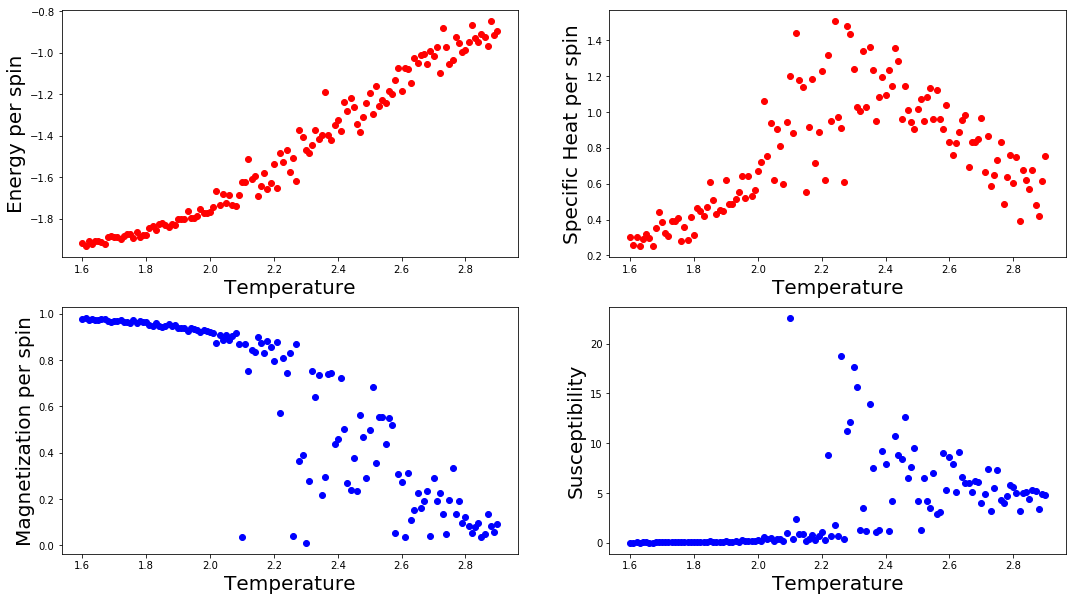

In [30]:
fig = plt.figure(figsize=(18, 10)) # plot the calculated values    

fig.add_subplot(2, 2, 1 )
plt.plot(temps, eneps_list8, 'ro')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Energy per spin", fontsize=20)

fig.add_subplot(2, 2, 2 )
plt.plot(temps, spec_heat8, 'ro')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Specific Heat per spin", fontsize=20)

fig.add_subplot(2, 2, 3 )
plt.plot(temps, abs(magps_list8), 'bo')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Magnetization per spin", fontsize=20)

fig.add_subplot(2, 2, 4 )
plt.plot(temps, mag_sus8, 'bo')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Susceptibility", fontsize=20)

In [34]:
np.save('eneps_list8', eneps_list8)
np.save('spec_heat8', spec_heat8)
np.save('magps_list8', magps_list8)
np.save('mag_sus8', mag_sus8)
np.save('ene_dict8', energy_dict8)
np.save('mag_dict8', mag_dict8)

In [133]:
temps = [t for t in np.arange(1.6, 2.91, .01)]
for i in range(len(temps)):
    temps[i] = round_to_3(temps[i])
    
t_points = len(temps)

# initialize dictionaries to store values
energy_dict10 = {}
mag_dict10 = {}

for T in temps:
    energy_dict10[str(T)] = []
    mag_dict10[str(T)] = []

# initialize lists to plot
eneps_list10 = np.zeros(t_points)
magps_list10 = np.zeros(t_points)
spec_heat10 = np.zeros(t_points)
mag_sus10 = np.zeros(t_points)

# initialize to T = 0
ones10 = 1*np.ones((10,10)) 

# rough estimate for equilibration time; 100*N many sweeps
n_eq = 100*10

# number of sweeps to average over
n = 50*10

# factors for averaging
n1 = 1/(n * 10**2)
n2 = 1/(n**2 * 10**2)

In [134]:
start = time.time()

grid = copy.copy(ones10)

for i in range(t_points):
    T = temps[i]
    boltz = {"4.0" : np.exp(-8/T), "2.0" : np.exp(-4/T)}
    
    for j in range(n_eq):
        grid = mc_sweep(grid, boltz)           # starts from the final config of the last temperature
    
    # initialize the totals that will be used to compute averages
    e_total = 0
    e2_total = 0
    mag_total = 0
    mag2_total= 0
    
    # measurements to average
    for k in range(n):
        grid = mc_sweep(grid, boltz)            
        energy = ising_energy(grid)             # only taking measurements every sweep
        mag = np.sum(grid)
        
        energy_dict10[str(T)].append(energy)
        mag_dict10[str(T)].append(mag)
        
        e_total += energy
        e2_total += energy*energy
        mag_total += mag
        mag2_total += mag*mag
    
    # compute averages
    eneps_list10[i] = n1*e_total
    magps_list10[i] = n1*mag_total
    spec_heat10[i] = (n1*e2_total - n2*e_total*e_total)/(T*T)
    mag_sus10[i] = (n1*mag2_total - n2*mag_total*mag_total)/T
    
    if (1.599 < T < 1.601) or (1.899 < T < 1.901) or (2.199 < T < 2.201) or (2.499 < T < 2.501):
        tick = time.time()
        print(f'T = {T}; {tick - start} seconds')
        
        
end = time.time()
print(f'Total time: {end - start}')   

T = 1.6; 0.7405281066894531 seconds
T = 1.9; 23.548583269119263 seconds
T = 2.2; 45.437055349349976 seconds
T = 2.5; 68.03927159309387 seconds
Total time: 98.5378041267395


Text(0,0.5,'Susceptibility')

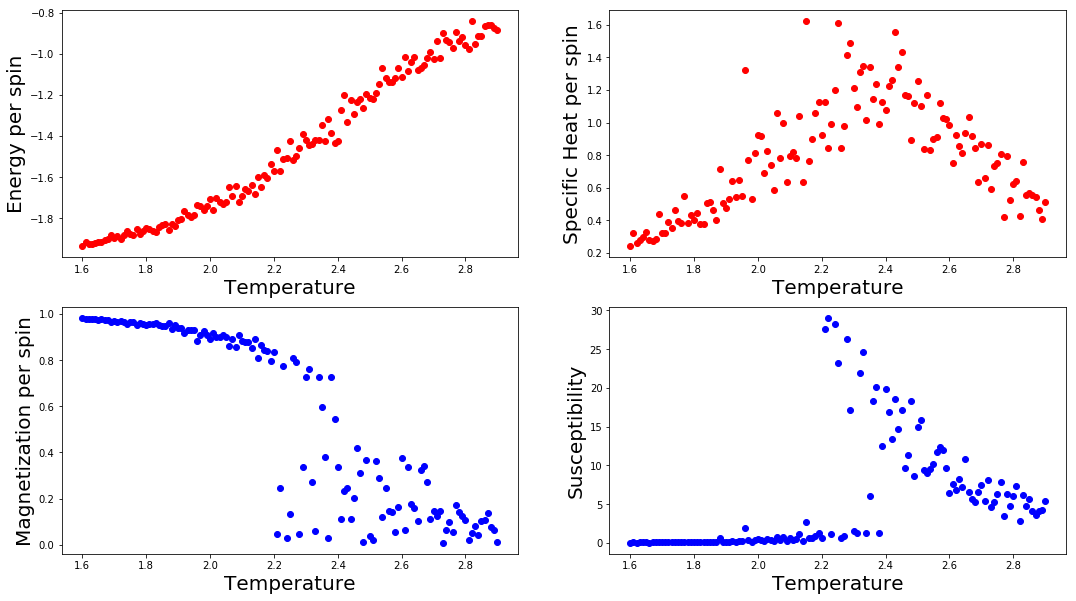

In [135]:
fig = plt.figure(figsize=(18, 10)) # plot the calculated values    

fig.add_subplot(2, 2, 1 )
plt.plot(temps, eneps_list10, 'ro')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Energy per spin", fontsize=20)

fig.add_subplot(2, 2, 2 )
plt.plot(temps, spec_heat10, 'ro')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Specific Heat per spin", fontsize=20)

fig.add_subplot(2, 2, 3 )
plt.plot(temps, abs(magps_list10), 'bo')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Magnetization per spin", fontsize=20)

fig.add_subplot(2, 2, 4 )
plt.plot(temps, mag_sus10, 'bo')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Susceptibility", fontsize=20)

In [136]:
np.save('eneps_list10', eneps_list10)
np.save('spec_heat10', spec_heat10)
np.save('magps_list10', magps_list10)
np.save('mag_sus10', mag_sus10)
np.save('ene_dict10', energy_dict10)
np.save('mag_dict10', mag_dict10)

In [149]:
temps = [t for t in np.arange(1.6, 2.91, .01)]
for i in range(len(temps)):
    temps[i] = round_to_3(temps[i])
    
t_points = len(temps)

# initialize dictionaries to store values
energy_dict15 = {}
mag_dict15 = {}

for T in temps:
    energy_dict15[str(T)] = []
    mag_dict15[str(T)] = []

# initialize lists to plot
eneps_list15 = np.zeros(t_points)
magps_list15 = np.zeros(t_points)
spec_heat15 = np.zeros(t_points)
mag_sus15 = np.zeros(t_points)

# initialize to T = 0
ones15 = 1*np.ones((15,15)) 

# rough estimate for equilibration time; 100*N many sweeps
n_eq = 100*15

# number of sweeps to average over
n = 50*15

# factors for averaging
n1 = 1/(n * 15**2)
n2 = 1/(n**2 * 15**2)

In [150]:
start = time.time()

grid = copy.copy(ones15)

for i in range(t_points):
    T = temps[i]
    boltz = {"4.0" : np.exp(-8/T), "2.0" : np.exp(-4/T)}
    
    for j in range(n_eq):
        grid = mc_sweep(grid, boltz)           # starts from the final config of the last temperature
    
    # initialize the totals that will be used to compute averages
    e_total = 0
    e2_total = 0
    mag_total = 0
    mag2_total= 0
    
    # measurements to average
    for k in range(n):
        grid = mc_sweep(grid, boltz)            
        energy = ising_energy(grid)             # only taking measurements every sweep
        mag = np.sum(grid)
        
        energy_dict15[str(T)].append(energy)
        mag_dict15[str(T)].append(mag)
        
        e_total += energy
        e2_total += energy*energy
        mag_total += mag
        mag2_total += mag*mag
    
    # compute averages
    eneps_list15[i] = n1*e_total
    magps_list15[i] = n1*mag_total
    spec_heat15[i] = (n1*e2_total - n2*e_total*e_total)/(T*T)
    mag_sus15[i] = (n1*mag2_total - n2*mag_total*mag_total)/T
    
    if (1.599 < T < 1.601) or (1.899 < T < 1.901) or (2.199 < T < 2.201) or (2.499 < T < 2.501):
        tick = time.time()
        print(f'T = {T}; {tick - start} seconds')
        
        
end = time.time()
print(f'Total time: {end - start}')   

T = 1.6; 2.8133108615875244 seconds
T = 1.9; 87.86190390586853 seconds
T = 2.2; 172.55089735984802 seconds
T = 2.5; 256.65163469314575 seconds
Total time: 368.8175296783447


Text(0,0.5,'Susceptibility')

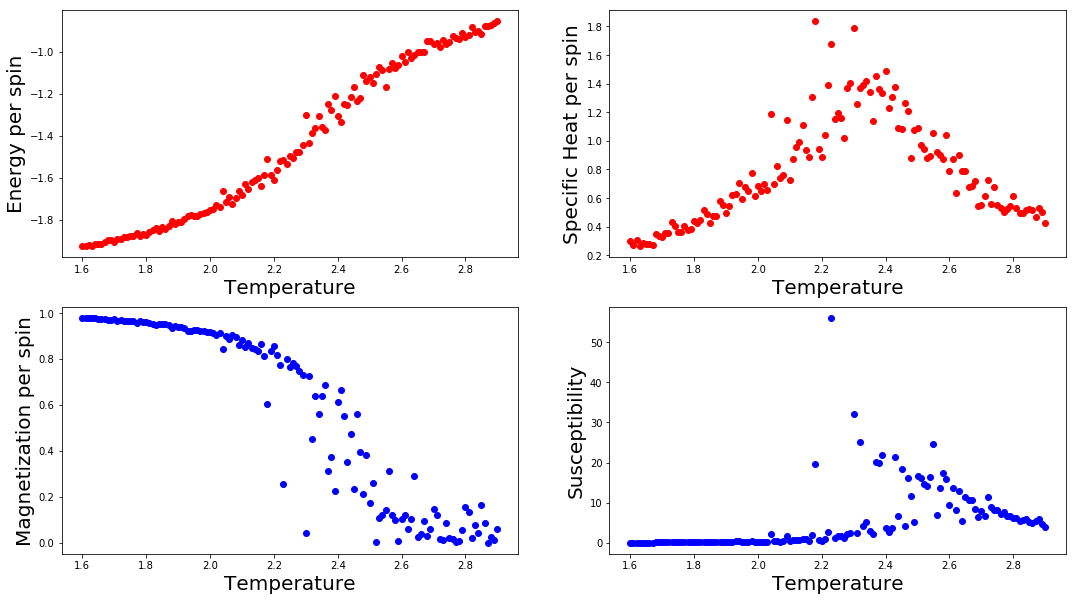

In [151]:
fig = plt.figure(figsize=(18, 10)) # plot the calculated values    

fig.add_subplot(2, 2, 1 )
plt.plot(temps, eneps_list15, 'ro')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Energy per spin", fontsize=20)

fig.add_subplot(2, 2, 2 )
plt.plot(temps, spec_heat15, 'ro')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Specific Heat per spin", fontsize=20)

fig.add_subplot(2, 2, 3 )
plt.plot(temps, abs(magps_list15), 'bo')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Magnetization per spin", fontsize=20)

fig.add_subplot(2, 2, 4 )
plt.plot(temps, mag_sus15, 'bo')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Susceptibility", fontsize=20)

In [152]:
np.save('eneps_list15', eneps_list15)
np.save('spec_heat15', spec_heat15)
np.save('magps_list15', magps_list15)
np.save('mag_sus15', mag_sus15)
np.save('ene_dict15', energy_dict15)
np.save('mag_dict15', mag_dict15)

In [157]:
temps = [t for t in np.arange(1.6, 2.91, .01)]
for i in range(len(temps)):
    temps[i] = round_to_3(temps[i])
    
t_points = len(temps)

# initialize dictionaries to store values
energy_dict20 = {}
mag_dict20 = {}

for T in temps:
    energy_dict20[str(T)] = []
    mag_dict20[str(T)] = []

# initialize lists to plot
eneps_list20 = np.zeros(t_points)
magps_list20 = np.zeros(t_points)
spec_heat20 = np.zeros(t_points)
mag_sus20 = np.zeros(t_points)

# initialize to T = 0
ones20 = 1*np.ones((20,20)) 

# rough estimate for equilibration time; 100*N many sweeps
n_eq = 100*20

# number of sweeps to average over
n = 50*20

# factors for averaging
n1 = 1/(n * 20**2)
n2 = 1/(n**2 * 20**2)

In [158]:
start = time.time()

grid = copy.copy(ones20)

for i in range(t_points):
    T = temps[i]
    boltz = {"4.0" : np.exp(-8/T), "2.0" : np.exp(-4/T)}
    
    for j in range(n_eq):
        grid = mc_sweep(grid, boltz)           # starts from the final config of the last temperature
    
    # initialize the totals that will be used to compute averages
    e_total = 0
    e2_total = 0
    mag_total = 0
    mag2_total= 0
    
    # measurements to average
    for k in range(n):
        grid = mc_sweep(grid, boltz)            
        energy = ising_energy(grid)             # only taking measurements every sweep
        mag = np.sum(grid)
        
        energy_dict20[str(T)].append(energy)
        mag_dict20[str(T)].append(mag)
        
        e_total += energy
        e2_total += energy*energy
        mag_total += mag
        mag2_total += mag*mag
    
    # compute averages
    eneps_list20[i] = n1*e_total
    magps_list20[i] = n1*mag_total
    spec_heat20[i] = (n1*e2_total - n2*e_total*e_total)/(T*T)
    mag_sus20[i] = (n1*mag2_total - n2*mag_total*mag_total)/T
    
    if (1.599 < T < 1.601) or (1.899 < T < 1.901) or (2.199 < T < 2.201) or (2.499 < T < 2.501):
        tick = time.time()
        print(f'T = {T}; {tick - start} seconds')
        
        
end = time.time()
print(f'Total time: {end - start}')   

T = 1.6; 4.965454339981079 seconds
T = 1.9; 213.78286743164062 seconds
T = 2.2; 426.05739641189575 seconds
T = 2.5; 632.793096780777 seconds
Total time: 829.0532813072205


Text(0,0.5,'Susceptibility')

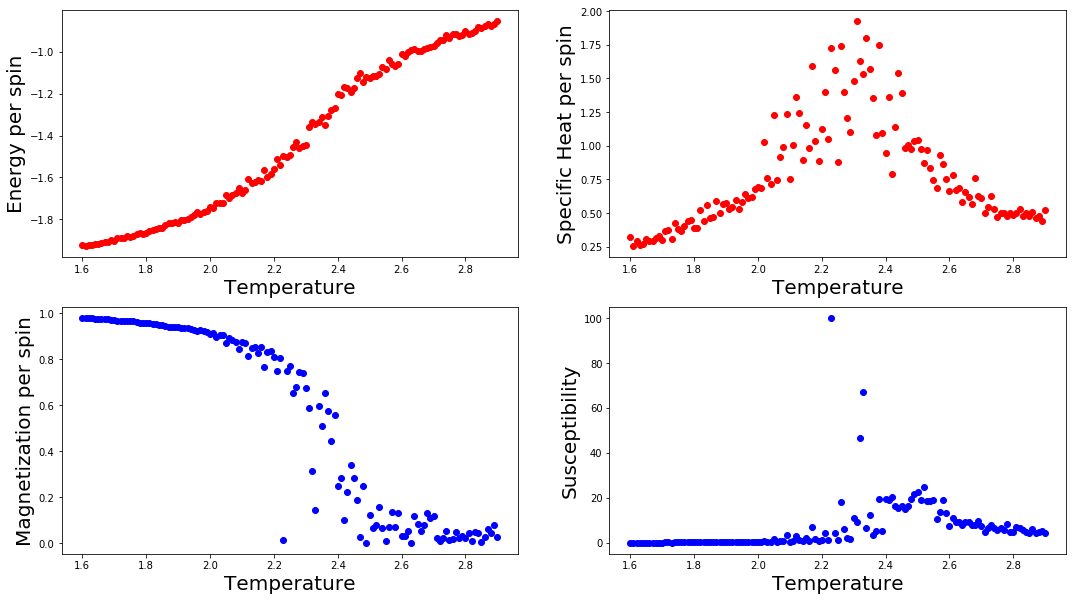

In [159]:
fig = plt.figure(figsize=(18, 10)) # plot the calculated values    

fig.add_subplot(2, 2, 1 )
plt.plot(temps, eneps_list20, 'ro')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Energy per spin", fontsize=20)

fig.add_subplot(2, 2, 2 )
plt.plot(temps, spec_heat20, 'ro')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Specific Heat per spin", fontsize=20)

fig.add_subplot(2, 2, 3 )
plt.plot(temps, abs(magps_list20), 'bo')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Magnetization per spin", fontsize=20)

fig.add_subplot(2, 2, 4 )
plt.plot(temps, mag_sus20, 'bo')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Susceptibility", fontsize=20)

In [163]:
np.save('eneps_list20', eneps_list20)
np.save('spec_heat20', spec_heat20)
np.save('magps_list20', magps_list20)
np.save('mag_sus20', mag_sus20)
np.save('ene_dict20', energy_dict20)
np.save('mag_dict20', mag_dict20)

In [164]:
# initialize to T = 0
ones25 = 1*np.ones((25,25)) 

temps = [t for t in np.arange(1.6, 2.91, .01)]
for i in range(len(temps)):
    temps[i] = round_to_3(temps[i])
    
t_points = len(temps)


# initialize dictionaries to store values
energy_dict25 = {}
mag_dict25 = {}

for T in temps:
    energy_dict25[str(T)] = []
    mag_dict25[str(T)] = []

# initialize lists to plot
eneps_list25 = np.zeros(t_points)
magps_list25 = np.zeros(t_points)
spec_heat25 = np.zeros(t_points)
mag_sus25 = np.zeros(t_points)

# rough estimate for equilibration time; 100*N many sweeps
n_eq = 100*25

# number of sweeps to average over
n = 50*25

# factors for averaging
n1 = 1/(n * 25**2)
n2 = 1/(n**2 * 25**2)

In [165]:
start = time.time()

grid = copy.copy(ones25)

for i in range(t_points):
    T = temps[i]
    boltz = {"4.0" : np.exp(-8/T), "2.0" : np.exp(-4/T)}
    
    for j in range(n_eq):
        grid = mc_sweep(grid, boltz)           # starts from the final config of the last temperature
    
    # initialize the totals that will be used to compute averages
    e_total = 0
    e2_total = 0
    mag_total = 0
    mag2_total= 0
    
    # measurements to average
    for k in range(n):
        grid = mc_sweep(grid, boltz)            
        energy = ising_energy(grid)             # only taking measurements every sweep
        mag = np.sum(grid)
        
        energy_dict25[str(T)].append(energy)
        mag_dict25[str(T)].append(mag)
        
        e_total += energy
        e2_total += energy*energy
        mag_total += mag
        mag2_total += mag*mag
    
    # compute averages
    eneps_list25[i] = n1*e_total
    magps_list25[i] = n1*mag_total
    spec_heat25[i] = (n1*e2_total - n2*e_total*e_total)/(T*T)
    mag_sus25[i] = (n1*mag2_total - n2*mag_total*mag_total)/T
    
    if (1.599 < T < 1.601) or (1.899 < T < 1.901) or (2.199 < T < 2.201) or (2.499 < T < 2.501):
        tick = time.time()
        print(f'T = {T}; {tick - start} seconds')
        
        
end = time.time()
print(f'Total time: {end - start}')   

T = 1.6; 9.359020471572876 seconds
T = 1.9; 345.2763862609863 seconds
T = 2.2; 759.1986503601074 seconds
T = 2.5; 1144.0126700401306 seconds
Total time: 1555.8557028770447


Text(0,0.5,'Susceptibility')

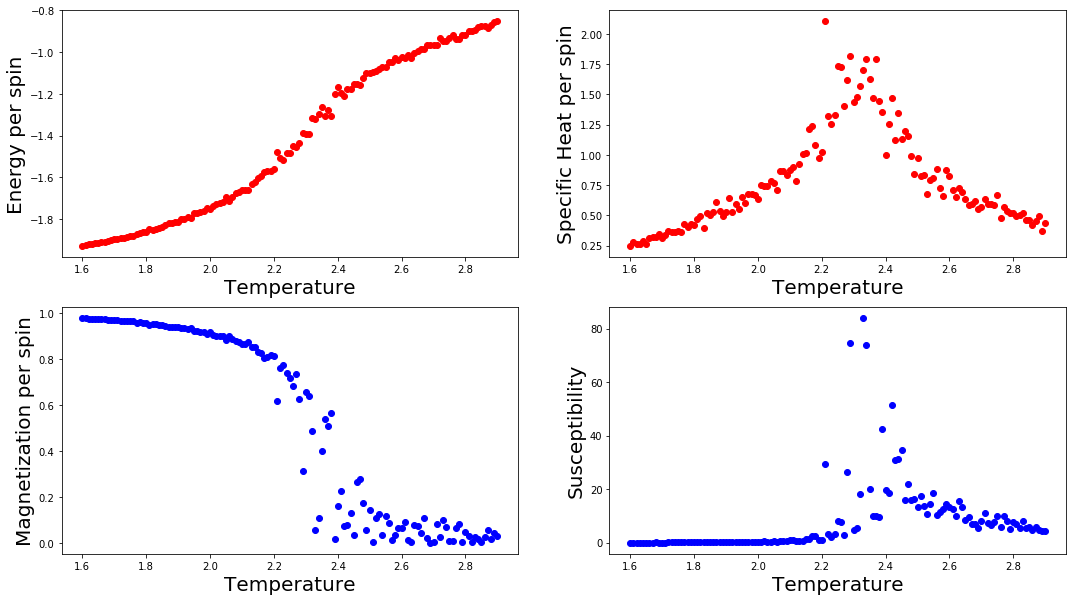

In [166]:
fig = plt.figure(figsize=(18, 10)) # plot the calculated values    

fig.add_subplot(2, 2, 1 )
plt.plot(temps, eneps_list25, 'ro')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Energy per spin", fontsize=20)

fig.add_subplot(2, 2, 2 )
plt.plot(temps, spec_heat25, 'ro')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Specific Heat per spin", fontsize=20)

fig.add_subplot(2, 2, 3 )
plt.plot(temps, abs(magps_list25), 'bo')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Magnetization per spin", fontsize=20)

fig.add_subplot(2, 2, 4 )
plt.plot(temps, mag_sus25, 'bo')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Susceptibility", fontsize=20)

In [167]:
np.save('eneps_list25', eneps_list25)
np.save('spec_heat25', spec_heat25)
np.save('magps_list25', magps_list25)
np.save('mag_sus25', mag_sus25)
np.save('ene_dict25', energy_dict25)
np.save('mag_dict25', mag_dict25)

In [172]:
# initialize to T = 0
ones30 = 1*np.ones((30,30)) 

temps = [t for t in np.arange(1.6, 2.91, .01)]
for i in range(len(temps)):
    temps[i] = round_to_3(temps[i])
    
t_points = len(temps)


# initialize dictionaries to store values
energy_dict30 = {}
mag_dict30 = {}

for T in temps:
    energy_dict30[str(T)] = []
    mag_dict30[str(T)] = []

# initialize lists to plot
eneps_list30 = np.zeros(t_points)
magps_list30 = np.zeros(t_points)
spec_heat30 = np.zeros(t_points)
mag_sus30 = np.zeros(t_points)

# rough estimate for equilibration time; 100*N many sweeps
n_eq = 100*30

# number of sweeps to average over
n = 50*30

# factors for averaging
n1 = 1/(n * 30**2)
n2 = 1/(n**2 * 30**2)

In [173]:
start = time.time()

grid = copy.copy(ones30)

for i in range(t_points):
    T = temps[i]
    boltz = {"4.0" : np.exp(-8/T), "2.0" : np.exp(-4/T)}
    
    for j in range(n_eq):
        grid = mc_sweep(grid, boltz)           # starts from the final config of the last temperature
    
    # initialize the totals that will be used to compute averages
    e_total = 0
    e2_total = 0
    mag_total = 0
    mag2_total= 0
    
    # measurements to average
    for k in range(n):
        grid = mc_sweep(grid, boltz)            
        energy = ising_energy(grid)             # only taking measurements every sweep
        mag = np.sum(grid)
        
        energy_dict30[str(T)].append(energy)
        mag_dict30[str(T)].append(mag)
        
        e_total += energy
        e2_total += energy*energy
        mag_total += mag
        mag2_total += mag*mag
    
    # compute averages
    eneps_list30[i] = n1*e_total
    magps_list30[i] = n1*mag_total
    spec_heat30[i] = (n1*e2_total - n2*e_total*e_total)/(T*T)
    mag_sus30[i] = (n1*mag2_total - n2*mag_total*mag_total)/T
    
    if (1.599 < T < 1.601) or (1.899 < T < 1.901) or (2.199 < T < 2.201) or (2.499 < T < 2.501):
        tick = time.time()
        print(f'T = {T}; {tick - start} seconds')
        
        
end = time.time()
print(f'Total time: {end - start}')   

T = 1.6; 16.982041358947754 seconds
T = 1.9; 512.8910920619965 seconds
T = 2.2; 1001.7564492225647 seconds
T = 2.5; 1485.4966404438019 seconds
Total time: 2130.421892642975


Text(0,0.5,'Susceptibility')

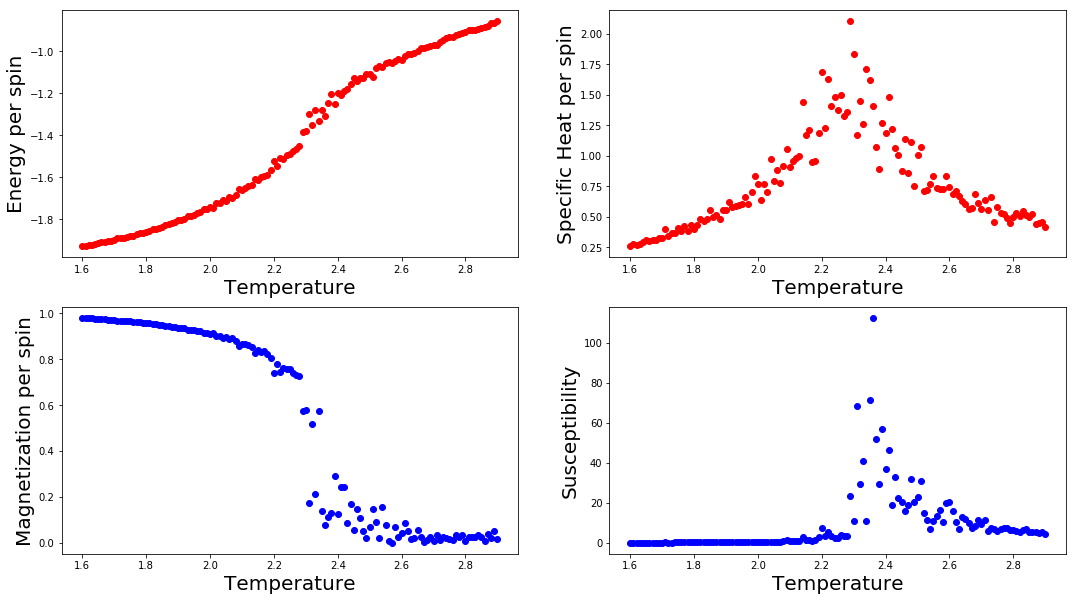

In [174]:
fig = plt.figure(figsize=(18, 10)) # plot the calculated values    

fig.add_subplot(2, 2, 1 )
plt.plot(temps, eneps_list30, 'ro')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Energy per spin", fontsize=20)

fig.add_subplot(2, 2, 2 )
plt.plot(temps, spec_heat30, 'ro')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Specific Heat per spin", fontsize=20)

fig.add_subplot(2, 2, 3 )
plt.plot(temps, abs(magps_list30), 'bo')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Magnetization per spin", fontsize=20)

fig.add_subplot(2, 2, 4 )
plt.plot(temps, mag_sus30, 'bo')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Susceptibility", fontsize=20)

In [175]:
np.save('eneps_list30', eneps_list30)
np.save('spec_heat30', spec_heat30)
np.save('magps_list30', magps_list30)
np.save('mag_sus30', mag_sus30)
np.save('ene_dict30', energy_dict30)
np.save('mag_dict30', mag_dict30)

In [23]:
# initialize to T = 0
ones50 = 1*np.ones((50,50)) 

temps = [t for t in np.arange(1.6, 2.91, .01)]
for i in range(len(temps)):
    temps[i] = round_to_3(temps[i])
    
t_points = len(temps)


# initialize dictionaries to store values
energy_dict50 = {}
mag_dict50 = {}

for T in temps:
    energy_dict50[str(T)] = []
    mag_dict50[str(T)] = []

# initialize lists to plot
eneps_list50 = np.zeros(t_points)
magps_list50 = np.zeros(t_points)
spec_heat50 = np.zeros(t_points)
mag_sus50 = np.zeros(t_points)

# rough estimate for equilibration time; 100*N many sweeps
n_eq = 100*50

# number of sweeps to average over
n = 50*50

# factors for averaging
n1 = 1/(n * 50**2)
n2 = 1/(n**2 * 50**2)

In [24]:
start = time.time()

grid = copy.copy(ones50)

for i in range(t_points):
    T = temps[i]
    boltz = {"4.0" : np.exp(-8/T), "2.0" : np.exp(-4/T)}
    
    for j in range(n_eq):
        grid = mc_sweep(grid, boltz)           # starts from the final config of the last temperature
    
    # initialize the totals that will be used to compute averages
    e_total = 0
    e2_total = 0
    mag_total = 0
    mag2_total= 0
    
    # measurements to average
    for k in range(n):
        grid = mc_sweep(grid, boltz)            
        energy = ising_energy(grid)             # only taking measurements every sweep
        mag = np.sum(grid)
        
        energy_dict50[str(T)].append(energy)
        mag_dict50[str(T)].append(mag)
        
        e_total += energy
        e2_total += energy*energy
        mag_total += mag
        mag2_total += mag*mag
    
    # compute averages
    eneps_list50[i] = n1*e_total
    magps_list50[i] = n1*mag_total
    spec_heat50[i] = (n1*e2_total - n2*e_total*e_total)/(T*T)
    mag_sus50[i] = (n1*mag2_total - n2*mag_total*mag_total)/T
    
    if (1.599 < T < 1.601) or (1.899 < T < 1.901) or (2.199 < T < 2.201) or (2.499 < T < 2.501):
        tick = time.time()
        print(f'T = {T}; {tick - start} seconds')
        
        
end = time.time()
print(f'Total time: {end - start}')   

T = 1.6; 76.16176414489746 seconds
T = 1.9; 2343.601623058319 seconds
T = 2.2; 4791.037336349487 seconds
T = 2.5; 7591.67600774765 seconds
Total time: 11537.145748853683


Text(0,0.5,'Susceptibility')

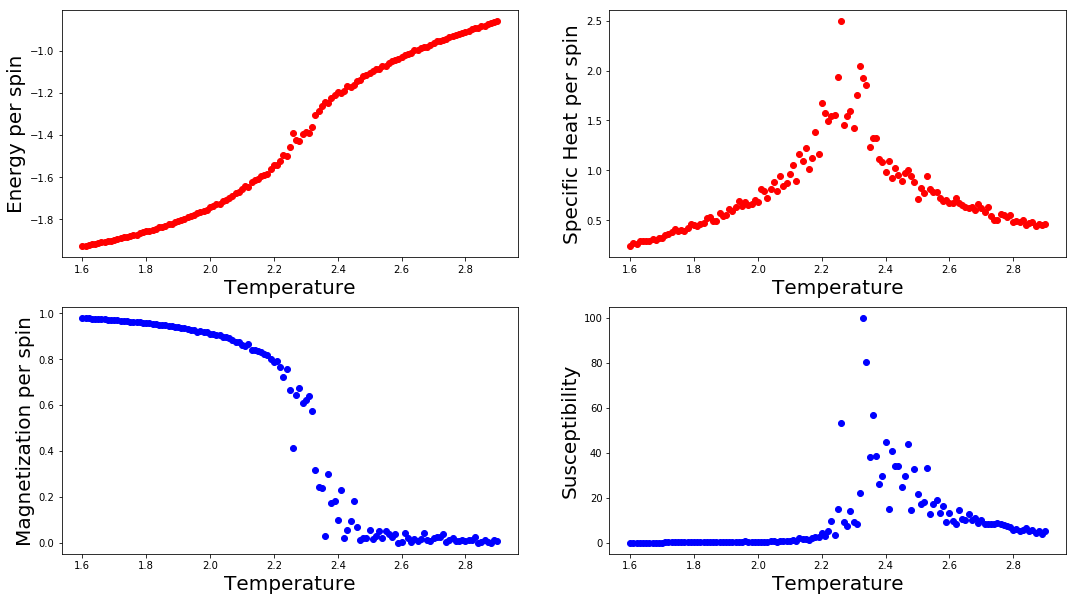

In [25]:
fig = plt.figure(figsize=(18, 10)) # plot the calculated values    

fig.add_subplot(2, 2, 1 )
plt.plot(temps, eneps_list50, 'ro')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Energy per spin", fontsize=20)

fig.add_subplot(2, 2, 2 )
plt.plot(temps, spec_heat50, 'ro')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Specific Heat per spin", fontsize=20)

fig.add_subplot(2, 2, 3 )
plt.plot(temps, abs(magps_list50), 'bo')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Magnetization per spin", fontsize=20)

fig.add_subplot(2, 2, 4 )
plt.plot(temps, mag_sus50, 'bo')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Susceptibility", fontsize=20)

In [ ]:
np.save('eneps_list50v3', eneps_list50)
np.save('spec_heat50v3', spec_heat50)
np.save('magps_list50v3', magps_list50)
np.save('mag_sus50v3', mag_sus50)
np.save('ene_dict50v3', energy_dict50)
np.save('mag_dict50v3', mag_dict50)

The magnetization per spin predicts $T_c = 2.269$ - $2.301$ and $\alpha' = .109$ - $.131$. (highly variable depending on which points you keep for the refression)

The magnetization per spin predicts $T_c = 2.367$ and $\gamma' = 1.600$ - $1.811$.

The simulation is entirely unable to determine the critical exponent for the specific heat -- this is likely because the discontinuous drop of the specific heat cannot be modeled by our finite size lattice, coupled with the instability and lack of temperature resolution.